In [6]:
from concurrent.futures import ThreadPoolExecutor
from pyrorb.client import RorbClient
from pyrorb.file_manager import FileManager
from pathlib import Path
import uuid
from pyrorb.config_manager import ConfigManager

config_manager = ConfigManager('../../config.json')

ENDPOINT =config_manager.get('endpoint')

class RorbProcessor:
    def __init__(self, catg_files, storm_files, save_path='temp', folder_name=None):
        
        
        self.folder_name=folder_name or str(uuid.uuid4())
        self.save_path = Path(save_path) / self.folder_name
        self.save_path.mkdir(parents=True, exist_ok=True)

        self.endpoint=ENDPOINT
        self.catg_files = catg_files
        self.storm_files=storm_files

        
        self.kc=4.35
        self.m=0.8
        self.il=18
        self.cl=7


        self.fm = FileManager(self.save_path)
        self.rorb_client = RorbClient(self.save_path, self.endpoint)

        self.chunk_size=20

        self.to_be_cleared=[]
    
    def amend_catg(self, find_text, replace_with, suffix=None):
        # TODO: make sure only and only one occurance of the find_txt is there.
        self.original_catg_files = self.catg_files
        new_catg_files = []
        suffix = suffix or str(uuid.uuid4())[:4]
        for file in self.catg_files:
            save_to = self.save_path/(Path(file).stem+suffix+Path(file).suffix)
            with open(file, 'r') as f:
                txt = f.read()
            txt=txt.replace(find_text, replace_with)

            with open(save_to, 'w') as f:
                f.write(txt)

            new_catg_files.append(save_to)
        self.catg_files= new_catg_files
        self.to_be_cleared += new_catg_files

    @property
    def file_list(self):
        return self.catg_files+self.storm_files
    
    @property
    def parameters(self):
        
        return self.fm.create_parameters(self.file_list, self.kc, self.m,self.il, self.cl)      

    @property
    def parameter_keys(self):
        return list(self.parameters.keys())

    def process_chunk(self, chunk_index):
        i = chunk_index * self.chunk_size
        zip_filename = self.fm.create_zip(self.file_list + self.parameter_keys[i:i+self.chunk_size], i)
        self.rorb_client.send_zip(zip_filename)
        self.to_be_cleared += list(self.parameters.keys()) + [zip_filename]

    def cleanup(self):
        self.fm.cleanup_files(self.to_be_cleared)
        self.to_be_cleared=[]
        self.catg_files=self.original_catg_files
        

    def run_parallel(self):
        # This is only works for complete chunks, should be fixed.
        num_chunks = len(self.parameters) // self.chunk_size
        with ThreadPoolExecutor(max_workers=5) as executor:
            executor.map(self.process_chunk, range(num_chunks))

    def get_outputs(self):
        return self.save_path.glob('*.out')



In [9]:
# Main execution
if __name__ == "__main__":
    x=1.1
    catg_files = ['/home/ashkan/sana_rorb_may24/RORB/Post-Developed-Storage sizing.catg']
    storm_files = [str(x) for x in Path('/home/ashkan/sana_rorb_may24/RORB/').glob('*.stm')][0:40]
    processor = RorbProcessor(catg_files, storm_files, folder_name=f'storage_coef_{x}')
    
    old_text = '''C Elevation-storage relationship
    1, 12, Elevation-storage table (2 values x 12 lines)                                                                                                         
                0.000,              0.000, 
                78.800,            437.920, 
                78.900,            458.200, 
                79.000,            478.270, 
                79.100,            498.100, 
                79.200,            518.420, 
                79.300,            539.250, 
                79.400,            560.990, 
                79.500,            584.430, 
                79.600,            609.630, 
                80.000,            709.630, 
                85.000,           1000.000, 
    -99
    '''

    new_text=f'''C Elevation-storage relationship
    1, 12, Elevation-storage table (2 values x 12 lines)                                                                                                         
                0.000,               {0.00*x}, 
                78.800,            {4379.20*x}, 
                78.900,            {4582.00*x}, 
                79.000,            {4782.70*x}, 
                79.100,            {4981.00*x}, 
                79.200,            {5184.20*x}, 
                79.300,            {5392.50*x}, 
                79.400,            {5609.90*x}, 
                79.500,            {5844.30*x}, 
                79.600,            {6096.30*x}, 
                80.000,            {7096.30*x}, 
                85.000,           {10000.00*x}, 
    -99
    '''
    processor.amend_catg(old_text, new_text, suffix=f'_{x}x')    
    processor.run_parallel()




PosixPath('temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du3hourtp21.parPost-Developed-Storage sizing_1.out')

In [17]:
from pyrorb import read_out
file_path = next(processor.get_outputs())
sections = read_out.read_sections(file_path)
hg = read_out.read_hydrographs(sections)
#metadata = read_out.extract_metadata_from_stm(file_path)

<Axes: xlabel='Time'>

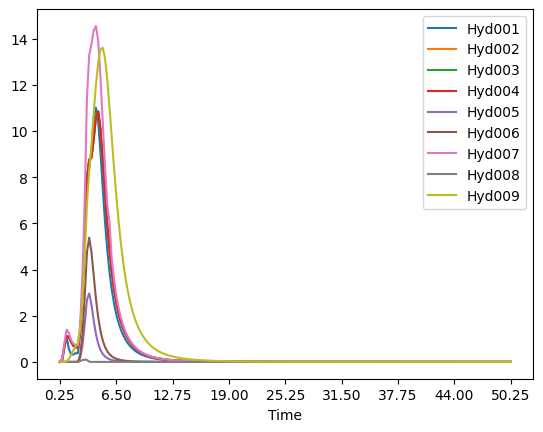

In [20]:
hg.plot()

In [8]:
processor.cleanup()

temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x.catg
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du1_5hourtp21.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du10mintp30.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du18hourtp21.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du3hourtp23.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du1hourtp23.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du48hourtp27.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du36hourtp26.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du1_5hourtp27.par
temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Po

FileNotFoundError: [Errno 2] No such file or directory: 'temp/storage_coef_1.1/Post-Developed-Storage sizing_1.1x_Post-Developed-Storage sizing_ aep1_du1_5hourtp21.par'